# DCN Goodreads Recommendation System

---
## Prepare the data

Setup

In [1]:
import json
import os
import numpy as np
import pandas as pd
from IPython.display import display
import pprint
import tensorflow as tf
import math
from tensorflow import keras
from tensorflow.keras import layers
import datetime

Dataset Directory

In [2]:
MODEL_DIR = './models/'

In [3]:
DIR = './data/cleaned/'
fn_books = 'goodreads_books_mystery_thriller_crime.pkl'
fn_reviews = 'goodreads_reviews_mystery_thriller_crime.pkl'
fn_genres = 'goodreads_book_genres_initial.pkl'

In [4]:
csv_fn_books = 'books.csv'
csv_fn_reviews = 'reviews.csv'

In [5]:
chunk_size = 500

book_dtype={
    "title": 'string', 
    "description": 'string', 
    "text_reviews_count": 'uint', 
    'average_rating': 'float'
}

review_dtype = {
'book_id': 'uint32',
'rating': 'uint8',
'review_text': 'string',
}

In [6]:
df_books = pd.read_csv(os.path.join(DIR, csv_fn_books), dtype=book_dtype, low_memory=True)
df_books.title = df_books.title.str.strip("b\'\"") 
df_books.set_index('book_id', inplace=True)
df_books.head()

,title,text_reviews_count,average_rating,description,author_id
book_id,,,,,
6066814,"Crowner Royal (Crowner John Mystery, #13)",15,3.93,"London, 1196. At the command of Richard the Li...",37778
33394837,The House of Memory (Pluto's Snitch #2),60,4.33,<NA>,242185
29074697,The Slaughtered Virgin of Zenopolis (Inspector...,23,3.49,"BATHS, BANKS AND ROMAN INSURRECTION Detective ...",15104629
1902202,"Dead in the Morning (Patrick Grant, #1)",8,3.30,"Gerald breezily introduced his wife, Helen, to...",190988
9671977,Aristotele e i misteri di Eleusi,3,3.54,"""I misteri di Eleusi"" e il quinto romanzo di A...",337108


In [7]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219235 entries, 6066814 to 26168430
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   title               219235 non-null  string 
 1   text_reviews_count  219235 non-null  uint32 
 2   average_rating      219235 non-null  float64
 3   description         198488 non-null  string 
 4   author_id           219235 non-null  int64  
dtypes: float64(1), int64(1), string(2), uint32(1)
memory usage: 9.2 MB


In [8]:
df_reviews = pd.read_csv(os.path.join(DIR, csv_fn_reviews), dtype=review_dtype, low_memory=True)
df_reviews.set_index('review_id', inplace=True)
df_reviews.head()

,user_id,book_id,rating,review_text
review_id,,,,
5e212a62bced17b4dbe41150e5bb9037,8842281e1d1347389f2ab93d60773d4d,6392944,3,I haven't read a fun mystery book in a while a...
2ede853b14dc4583f96cf5d120af636f,8842281e1d1347389f2ab93d60773d4d,28684704,3,"A fun, fast paced science fiction thriller. I ..."
8e4d61801907e591018bdc3442a9cf2b,8842281e1d1347389f2ab93d60773d4d,32283133,0,http://www.telegraph.co.uk/culture/10...
022bb6daffa49adc27f6b20b6ebeb37d,8842281e1d1347389f2ab93d60773d4d,17860739,4,An amazing and unique creation: JJ Abrams and ...
0e317947e1fd341f573192111bb2921d,8842281e1d1347389f2ab93d60773d4d,8694005,3,The Name of the Rose is a thrilling Dan Brown-...


In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 735000 entries, 5e212a62bced17b4dbe41150e5bb9037 to a91f52d910b3988d02d9c72d4731de3c
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      735000 non-null  object
 1   book_id      735000 non-null  uint32
 2   rating       735000 non-null  uint8 
 3   review_text  734832 non-null  string
dtypes: object(1), string(1), uint32(1), uint8(1)
memory usage: 20.3+ MB


### TODO: Maybe the Data should be indexed/grouped by BookID, not ReviewID

In [10]:
df_join = pd.merge(df_reviews, df_books, left_on="book_id", right_index=True)
df_join.head()

,user_id,book_id,rating,review_text,title,text_reviews_count,average_rating,description,author_id
review_id,,,,,,,,,
5e212a62bced17b4dbe41150e5bb9037,8842281e1d1347389f2ab93d60773d4d,6392944,3,I haven't read a fun mystery book in a while a...,"The Murder on the Links (Hercule Poirot, #2)",42,3.8,"On a French golf course, a millionaire is foun...",123715
ee9cf5e49795718b9bb086c1cde23116,24d87e891f6f60ae101c1de158cbe672,6392944,4,"A fun, fast read! I just adore reading books w...","The Murder on the Links (Hercule Poirot, #2)",42,3.8,"On a French golf course, a millionaire is foun...",123715
b5a6af59482018d0814c373723080adb,d083ade0fb4502508b1f3ce59bf1c7db,6392944,4,"Full of twists and turns, way better than the ...","The Murder on the Links (Hercule Poirot, #2)",42,3.8,"On a French golf course, a millionaire is foun...",123715
2ede853b14dc4583f96cf5d120af636f,8842281e1d1347389f2ab93d60773d4d,28684704,3,"A fun, fast paced science fiction thriller. I ...",Dark Matter,1026,4.1,"""Are you happy with your life?"" Those are the ...",442240
31db9238ec11ca671a65a50643f952b7,01ec1a320ffded6b2dd47833f2c8e4fb,28684704,5,"Mind-bending and completely unique, take a cha...",Dark Matter,1026,4.1,"""Are you happy with your life?"" Those are the ...",442240


In [11]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
Index: 735000 entries, 5e212a62bced17b4dbe41150e5bb9037 to a91f52d910b3988d02d9c72d4731de3c
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             735000 non-null  object 
 1   book_id             735000 non-null  uint32 
 2   rating              735000 non-null  uint8  
 3   review_text         734832 non-null  string 
 4   title               735000 non-null  string 
 5   text_reviews_count  735000 non-null  uint32 
 6   average_rating      735000 non-null  float64
 7   description         703758 non-null  string 
 8   author_id           735000 non-null  int64  
dtypes: float64(1), int64(1), object(1), string(3), uint32(2), uint8(1)
memory usage: 45.6+ MB


In [12]:
df_join.sample(20)

,user_id,book_id,rating,review_text,title,text_reviews_count,average_rating,description,author_id
review_id,,,,,,,,,
84b45c5862e66c41fde9f1922fd946f7,f10d3a1771caeffebde9fd239547f067,17899948,5,I didn't know anything about the storyline and...,Rebecca,4127,4.21,Last night I dreamt I went to Manderley again ...,2001717
5ba79c8f80f076d432d1eba5ea5b1453,11f5af0f11e1b73863c7a887ef0f2d37,70897,0,This is probably one of those have-to-be-there...,The Secret History,862,4.08,Truly deserving of the accolade Modern Classic...,8719
10e8c869bb59daf5d2f3fae4ab364d9c,c8c04f0d14b8a9c482b8d979a41f963d,37304,4,Davenport meets doctor Weather Karkinnen at a ...,"Winter Prey (Lucas Davenport, #5)",424,4.25,"It is winter in the remote, dark Wisconsin woo...",4610
c0a1b5b9e12ccac1d0e3ce7844f9dfc2,4a1a45c12198b9ec99c57efa91e957ce,17802724,4,I won this book in a first reads giveaway. I w...,The Husband's Secret,18009,3.92,At the heart of The Husband's Secret is a lett...,322069
49fda46bc527b4b2a0fa0342bf574881,ac74ae567651e7502fb4408fa0da9840,23168811,4,The author is becoming at ease with his main c...,Even the Dead (Quirke #7),161,3.77,"A suspicious death, a pregnant woman suddenly ...",116405
d9b941dfcb7ff9601aa54f1083b0e3d3,65dac923d96ed9e0e3667dd9850d16be,25812109,4,4.5 stars hell yes. everything but the roman...,The Female of the Species,2026,4.25,A contemporary YA novel that examines rape cul...,5351825
305a063bd1f0ce66b7ab3839971f6573,8f3e35dcd36b81c7161baa9c28d42b1d,13147906,1,"Well, it took me forever to listen to this. I ...",Gone Girl,636,4.03,"What are you thinking, Amy? The question I've ...",2383
8bf21fcb2c3122f1fb2b14545ffea48a,95e5bfa350481de0f8e073792a170219,215238,3,Certainly not his best book. author wrote a di...,Play Dead,804,3.74,Terrible secrets lead basketball star David Ba...,24689
5c01ae2e360087907e3d0a5a8698fb2d,c99afa5c1c37afb44d1f99aea34f6204,431,3,"Ok, just finished the book and I still not sur...",The New York Trilogy,1601,3.92,"Paul Auster's signature work, The New York Tri...",296961


before:

Index: 22726 entries, 0e317947e1fd341f573192111bb2921d to 921812c9edc173c6d12e000723b9e667

after:

Index: 735000 entries, 5e212a62bced17b4dbe41150e5bb9037 to a91f52d910b3988d02d9c72d4731de3c
(= number of reviews)

after dropNA():
703594 


In [13]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
Index: 735000 entries, 5e212a62bced17b4dbe41150e5bb9037 to a91f52d910b3988d02d9c72d4731de3c
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             735000 non-null  object 
 1   book_id             735000 non-null  uint32 
 2   rating              735000 non-null  uint8  
 3   review_text         734832 non-null  string 
 4   title               735000 non-null  string 
 5   text_reviews_count  735000 non-null  uint32 
 6   average_rating      735000 non-null  float64
 7   description         703758 non-null  string 
 8   author_id           735000 non-null  int64  
dtypes: float64(1), int64(1), object(1), string(3), uint32(2), uint8(1)
memory usage: 45.6+ MB


In [14]:
df_join.dropna(inplace=True)

In [15]:
df_join.describe()

,book_id,rating,text_reviews_count,average_rating,author_id
count,7.035940e+05,703594.000000,703594.000000,703594.000000,7.035940e+05
mean,1.317835e+07,3.672068,2735.980951,3.869114,2.033713e+06
std,1.054083e+07,1.193176,9487.515139,0.278711,3.437501e+06
min,1.640000e+02,0.000000,0.000000,0.000000,1.400000e+01
25%,1.744612e+06,3.000000,38.000000,3.720000,1.447300e+04
50%,1.312973e+07,4.000000,216.000000,3.890000,1.563270e+05
75%,2.232339e+07,5.000000,1148.000000,4.050000,3.057577e+06
max,3.646717e+07,5.000000,78438.000000,5.000000,1.733059e+07


In [16]:
data = df_join

In [17]:
data.sample(5)

,user_id,book_id,rating,review_text,title,text_reviews_count,average_rating,description,author_id
review_id,,,,,,,,,
544b25ef2e5bca5ed23de6e2ce334633,d991d4797cca0fff1cb9a1d6638eb47a,18770398,4,At one point it seemed I would be reading the ...,Night Film,2497,3.78,"Brilliant, haunting, breathtakingly suspensefu...",2362
14f2a43d1c9379f4fe1f0f0ee7ce9beb,34da92c91d6b2a2caddf03b8b714acb9,12875355,2,As a huge Austen fan I have been wanting to re...,Death Comes to Pemberley,6916,3.21,The world is classic Jane Austen. The mystery ...,344522
1ce7b0f009b45367e206bdb7fca2ecc4,1c28c471aa84a1ca3a8882a637d7a76d,34032606,5,This latest entry in the Laurel McKay series h...,"Dying for a Diamond (Laurel McKay Mysteries, #6)",14,4.53,"Warm breezes, tropical seas, a handsome new hu...",4115315
07f6064388bcbc76c324f89bc54f896b,c8d8cc9c1058c0caef590bf32001256c,25079805,4,After XO I was a little hesitant to jump into ...,"Solitude Creek (Kathryn Dance, #4)",14,3.85,"Jeffery Deaver, ""the master of manipulation"" (...",1612
53dc886b45ef2cffe422ca9fe619cfb7,7543b5a00e6dac232dd2a1c0ada849b9,12079574,4,Great start to a new series! I was apprehensiv...,Stay At Home Dead (Stay At Home Dad Mystery #1),107,3.88,"When Deuce Winters, a stay-at-home dad in slee...",6429000


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 703594 entries, 5e212a62bced17b4dbe41150e5bb9037 to a91f52d910b3988d02d9c72d4731de3c
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             703594 non-null  object 
 1   book_id             703594 non-null  uint32 
 2   rating              703594 non-null  uint8  
 3   review_text         703594 non-null  string 
 4   title               703594 non-null  string 
 5   text_reviews_count  703594 non-null  uint32 
 6   average_rating      703594 non-null  float64
 7   description         703594 non-null  string 
 8   author_id           703594 non-null  int64  
dtypes: float64(1), int64(1), object(1), string(3), uint32(2), uint8(1)
memory usage: 43.6+ MB


Let's split the data into training (80%) and test (20%) sets.

In [19]:
TARGET_FEATURE_NAME = "rating"  # individual rating
split = 0.8

In [20]:
train_splits = []
test_splits = []

for _, group_data in data.groupby(TARGET_FEATURE_NAME):
    random_selection = np.random.rand(len(group_data.index)) <= split
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")


Train split size: 562888
Test split size: 140706


~~Durch den Merge wurden aus (50k Büchern ∩ 100k Reviews ∩ 250k Genres) ≅ 10k kombinierte Datenpunkte!~~

~~Using left-join, 22k datapoints are left after merging~~

Now about 700k in Total, Train: 560k, Test: 140k :)

In [21]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

# train_data.to_csv(os.path.join(DIR, train_data_file), index=False)
# test_data.to_csv(os.path.join(DIR, test_data_file), index=False)

In [22]:
CSV_HEADER = list(train_data.columns)

pickle joined df

In [23]:
# data.to_pickle(os.path.join(DIR, "joined_df.pkl"))

---
## Define dataset metadata
Here, we define the metadata of the dataset that will be useful for reading and parsing the data into input features, and encoding the input features with respect to their types.



In [24]:
TARGET_FEATURE_LABELS = [i for i in range(6)]
# normalization
NUMERIC_FEATURE_NAMES = [
    "text_reviews_count",   # popularity
    "average_rating"
]
# text vectorization + embedding
TEXT_FEATURE_NAMES = [
    "review_text",
    "title",
    "description",
]
# integer lookup
CATEGORICAL_INT_FEATURE_NAMES = [
    "book_id",
    "author_id",
]
# string lookup
CATEGORICAL_STR_FEATURE_NAMES = [
    "user_id",
]
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(data["user_id"].unique()),
    "author_id": list(data["author_id"].unique()),
    "book_id": list(data["book_id"].unique()),
}


FEATURE_NAMES = NUMERIC_FEATURE_NAMES + \
                TEXT_FEATURE_NAMES + \
                CATEGORICAL_INT_FEATURE_NAMES + \
                CATEGORICAL_STR_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]


NUM_CLASSES = len(TARGET_FEATURE_LABELS)

---
## Experiment setup
Next, let's define an input function that reads and parses the file, then converts features and labels into a `tf.data.Dataset` for training or evaluation.



In [25]:
def get_dataset_from_pandas(dataframe, label_name, batch_size, shuffle=False):
    df = dataframe.copy()
    labels = df.pop(label_name)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [26]:
from email_callback import EmailCallback
dropout_rate = 0.1

hidden_units = [32, 32]


def run_experiment(model, loss=None, metrics=None, learning_rate=0.001, batch_size=128, num_epochs=50):
    import datetime
    _loss = loss if loss is not None else [keras.losses.SparseCategoricalCrossentropy()]
    _metrics = metrics if metrics is not None else [keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseCategoricalCrossentropy()]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=_loss,
        metrics=_metrics,
    )

    train_dataset = get_dataset_from_pandas(train_data, TARGET_FEATURE_NAME, batch_size, shuffle=True)

    test_dataset = get_dataset_from_pandas(test_data, TARGET_FEATURE_NAME, batch_size)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    email = EmailCallback(train_size=len(train_data), test_size=len(test_data))
    callbacks_train = [
        tf.keras.callbacks.TensorBoard(log_dir=log_dir),
        tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5),
        tf.keras.callbacks.experimental.BackupAndRestore(backup_dir="./models/backup"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
        email
    ]
    callbacks_test = [
        tf.keras.callbacks.TensorBoard(log_dir=log_dir),
        email
    ]

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs, callbacks=callbacks_train)
    print("Model training finished")

    metrics = model.evaluate(test_dataset, verbose=0, callbacks=callbacks_test)

    print(metrics)

    return history, metrics


In [27]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()


---
## Create model inputs
Now, define the inputs for the models as a dictionary, where the key is the feature name, and the value is a `keras.layers.Input` tensor with the corresponding feature shape and data type.



In [28]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in [*TEXT_FEATURE_NAMES, *CATEGORICAL_STR_FEATURE_NAMES]:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
    return inputs

---
## Encode features

We create two representations of our input features: sparse and dense: 1. In the *sparse* representation, the categorical features are encoded with one-hot encoding using the `CategoryEncoding` layer. This representation can be useful for the model to memorize particular feature values to make certain predictions. 2. In the *dense* representation, the categorical features are encoded with low-dimensional embeddings using the ``Embedding`` layer. This representation helps the model to generalize well to unseen feature combinations.



In [29]:
# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [30]:
from tensorflow.keras.layers import StringLookup, IntegerLookup

call = 1
def encode_inputs(inputs, use_embedding=False):
    global call
    call += 1
    encoded_features = []
    for feature_name in inputs:
        if feature_name in [*CATEGORICAL_STR_FEATURE_NAMES, *CATEGORICAL_INT_FEATURE_NAMES]:
            is_string = (feature_name in CATEGORICAL_STR_FEATURE_NAMES)
            lookup_class = StringLookup if is_string else IntegerLookup
            lookup_name = "string_lookup" if is_string else "integer_lookup"
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            lookup = lookup_class(
                vocabulary=vocabulary,
                output_mode="int" if use_embedding else "multi_hot",
                name=f"{lookup_name}_{feature_name}_{call}",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = 32 #int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary)+1, output_dim=embedding_dims,
                    name=f"{lookup_name}_embedding_{feature_name}_{call}",
                )
                
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        elif feature_name in TEXT_FEATURE_NAMES:
            vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_features, 
            output_sequence_length=sequence_length if use_embedding else None, output_mode="int" if use_embedding else "multi_hot",
            name=f"textvectorization_{feature_name}_{call}",
            )
            vectorize_layer.adapt(data[feature_name])
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = vectorize_layer(inputs[feature_name])
                embedding_dims = 32 #int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=vectorize_layer.vocabulary_size()+1, output_dim=embedding_dims,
                    name=f"tv_embedding_{feature_name}_{call}",
                )
                # average the embedding from sequence_length x batch to 1x32
                averaging = tf.keras.layers.GlobalAveragePooling1D();

                # Convert the index values to embedding representations.
                encoded_feature = averaging(embedding(encoded_feature))
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = vectorize_layer(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)
        
    all_features = layers.concatenate(encoded_features)
    return all_features


---
## Experiment 1: a baseline model
In the first experiment, let's create a multi-layer feed-forward network, where the categorical features are one-hot encoded.


In [31]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
plot_fn = os.path.join("./logs/model_plots/", "baseline_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")
keras.utils.plot_model(baseline_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


KeyboardInterrupt: 

In [ ]:
run_experiment(baseline_model)

setting up yagmail...
Start training the model...
Start Training with Model...
Starting training; got log keys: []
[]
Epoch 1/50
68/68 [==============================] - 31s 244ms/step - loss: 1.7859 - sparse_categorical_accuracy: 0.2787 - sparse_categorical_crossentropy: 1.78596s - loss: 1.8742 - sparse_categorical_accuracy: 0.2664 - sparse_catego
Epoch 2/50
68/68 [==============================] - 17s 249ms/step - loss: 1.5290 - sparse_categorical_accuracy: 0.3300 - sparse_categorical_crossentropy: 1.5290
Epoch 3/50
68/68 [==============================] - 15s 220ms/step - loss: 1.4537 - sparse_categorical_accuracy: 0.3711 - sparse_categorical_crossentropy: 1.4537
Epoch 4/50
68/68 [==============================] - 10s 146ms/step - loss: 1.4265 - sparse_categorical_accuracy: 0.3848 - sparse_categorical_crossentropy: 1.42650s - loss: 1.4254 - sparse_categorical_accuracy: 0.3834 - sparse_categorical_crossentropy:
Epoch 5/50
68/68 [==============================] - 8s 113ms/step - loss:

In [ ]:
baseline_model.save(os.path.join(MODEL_DIR, "baseline_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

INFO:tensorflow:Assets written to: ./models/baseline_model_20220125-175353\assets


INFO:tensorflow:Assets written to: ./models/baseline_model_20220125-175353\assets



Epoch 50/50
33/33 [==============================] - 3s 96ms/step - loss: 13.9775 - sparse_categorical_accuracy: 0.1705 - sparse_categorical_crossentropy: 1.7928

---

mit MAE funktionierts *überhaupt nicht*:

33/33 [==============================] - 6s 173ms/step - loss: 3.5591 - sparse_categorical_accuracy: 0.2904 - sparse_categorical_crossentropy: 1.8936

Model training finished

Test accuracy: 356.12. Test CategoricalCrossEntropy: 0.23%
(vermutlich werte umgekehrt)

Epoch 6/50
33/33 [==============================] - 15s 440ms/step - loss: 3.5591 - sparse_categorical_accuracy: 0.3038 - sparse_categorical_crossentropy: 1.8952

Model training finished
[3.561164140701294, 0.3306415379047394, 1.8279825448989868]

Epoch 43/50
33/33 [==============================] - 5s 143ms/step - loss: 0.4164 - sparse_categorical_accuracy: 0.8359
Model training finished
Test accuracy: 43.11%

Results w/ 8670 pieces of train data and baseline_model @ 15 epochs:
- loss: 0.7961 
- sparse_categorical_accuracy: 0.7035
- Test accuracy: 38.67 %

TODO: Datensatz fetching fixen, er hört sonst nach 16 epochs schon auf :o 8670/265er batches müsste für 32 reichen

## TODO andere Metrics, output ist ja nicht kategorisch, darf gern Regression sein, oder?

Learnings:
- eigentlich Klassifiziere ich gerade folgendes:
  - Gegeben Review mit Title, Beschreibung, Text, UserID, Author, etc. --> prädiziere die Bewertung von 0-5
  - (eigentlich recht easy)

- was ich für eine Recommendation bräuchte (-> Ranking)
- wäre eine prädizierte Bewertung **auf Basis der UserID** und Anhand der Buchfeatures Beschreibung, Titel, Author, etc.
- Dann "einfach" für alle Bücher prädizieren und top K Ergebnisse liefern --> MAP@k, Precision@k
  

wie im TF Tutorial beschrieben:
1. Candidate Model: --> Bücher --> Features
2. Query Model: --> Suchanfrage --> UserModel --> UserID
   - nicht ganz klar, wo die user-bewertungen jetzt konkret rein sollten..

RS-Tasks:
- *item rating prediction (regression)* [42]
- click-through rate prediction (binary classification) [11, 16]
- user behavior prediction (multi-class classification) [59], and
- *item retrieval (clustering)* [10].

In [ ]:
%tensorboard --logdir log_dir

UsageError: Line magic function `%tensorboard` not found.


---
## Experiment 2: Wide & Deep model
In the second experiment, we create a Wide & Deep model. The wide part of the model a linear model, while the deep part of the model is a multi-layer feed-forward network.

Use the sparse representation of the input features in the wide part of the model and the dense representation of the input features for the deep part of the model.

Note that every input features contributes to both parts of the model with different representations.



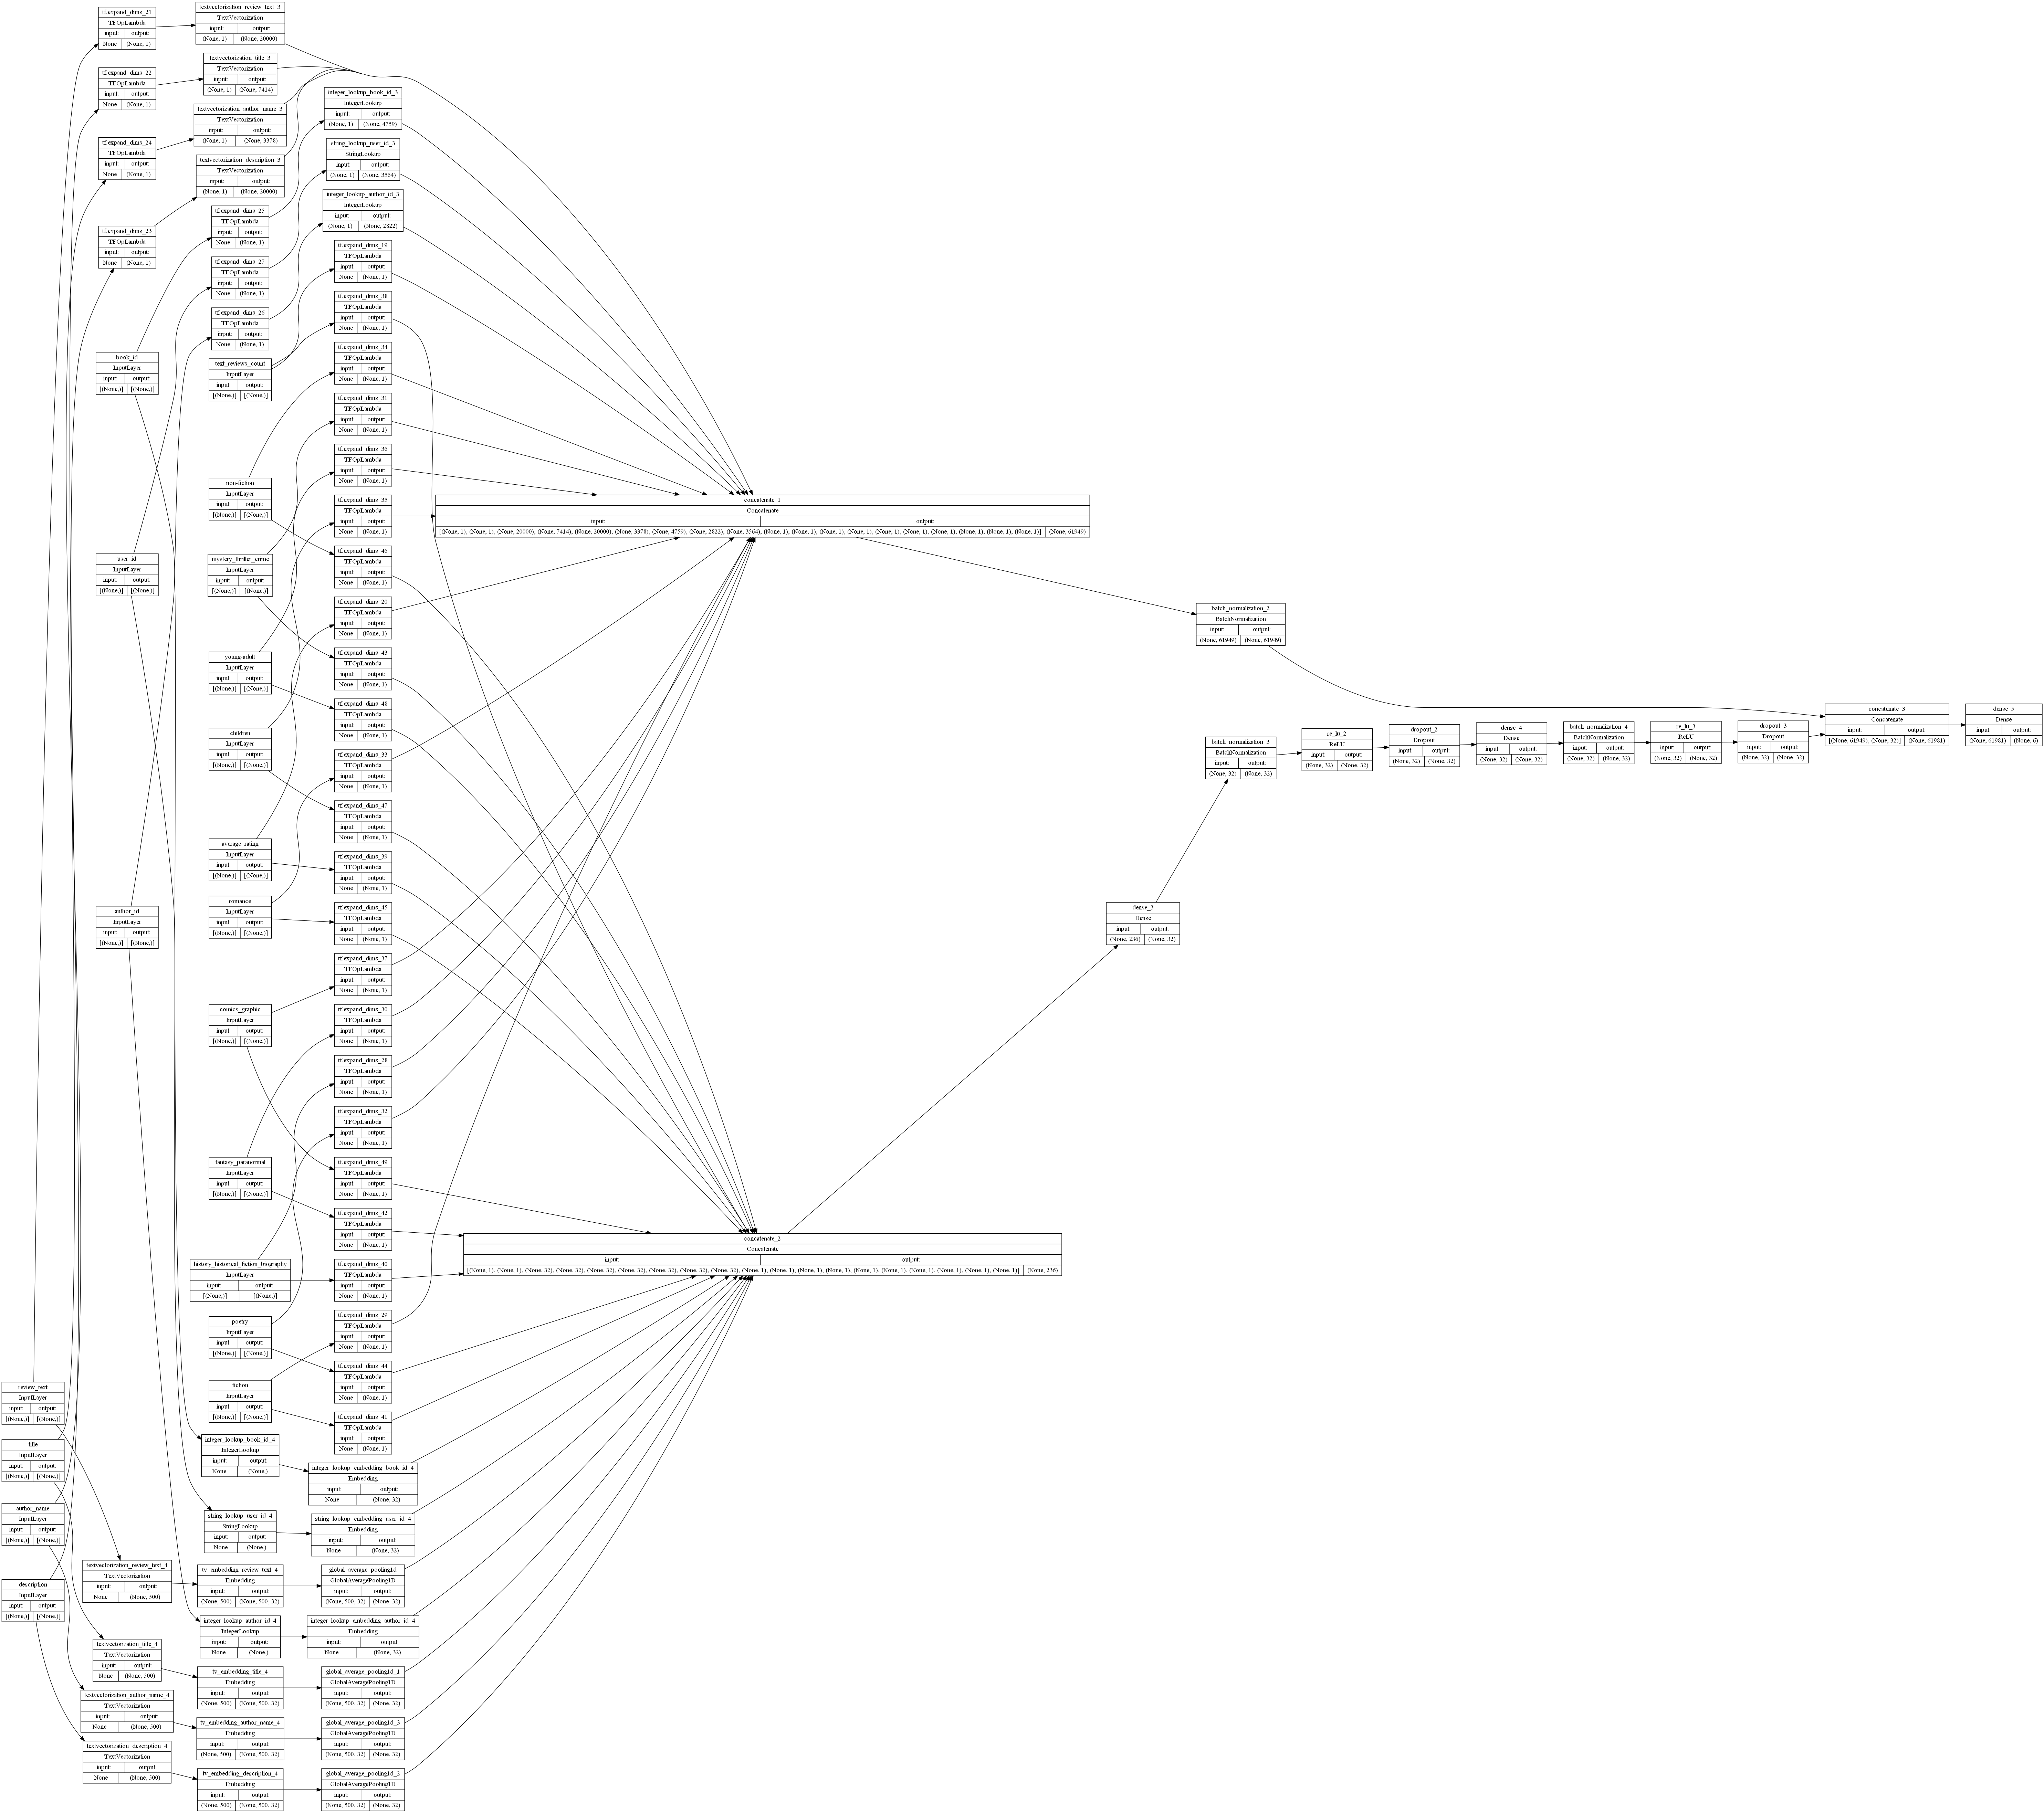

In [ ]:
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
plot_fn = os.path.join("./logs/model_plots/", "wide_and_deep_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")

keras.utils.plot_model(wide_and_deep_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [ ]:
run_experiment(wide_and_deep_model)

setting up yagmail...
Start training the model...
Start Training with Model...
Starting training; got log keys: []
[]
Epoch 1/50
 6/68 [=>............................] - ETA: 25s - loss: 1.7015 - sparse_categorical_accuracy: 0.2760 - sparse_categorical_crossentropy: 1.7015WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3443s vs `on_train_batch_end` time: 0.4042s). Check your callbacks.


68/68 [==============================] - 41s 347ms/step - loss: 1.7063 - sparse_categorical_accuracy: 0.3586 - sparse_categorical_crossentropy: 1.7063
Epoch 2/50
68/68 [==============================] - 22s 317ms/step - loss: 0.6265 - sparse_categorical_accuracy: 0.7656 - sparse_categorical_crossentropy: 0.6265
Epoch 3/50
68/68 [==============================] - 14s 212ms/step - loss: 0.4215 - sparse_categorical_accuracy: 0.8553 - sparse_categorical_crossentropy: 0.4215
Epoch 4/50
68/68 [==============================] - 14s 208ms/step - loss: 0.3050 - sparse_categorical_accuracy: 0.9043 - sparse_categorical_crossentropy: 0.3050
Epoch 5/50
68/68 [==============================] - 20s 288ms/step - loss: 0.2446 - sparse_categorical_accuracy: 0.9276 - sparse_categorical_crossentropy: 0.2446
Epoch 6/50
68/68 [==============================] - 12s 182ms/step - loss: 0.2053 - sparse_categorical_accuracy: 0.9420 - sparse_categorical_crossentropy: 0.2053
Epoch 7/50
68/68 [=====================

In [ ]:
wide_and_deep_model.save(os.path.join(MODEL_DIR, "wide_and_deep_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

INFO:tensorflow:Assets written to: ./models/wide_and_deep_model_20220125-180913\assets


INFO:tensorflow:Assets written to: ./models/wide_and_deep_model_20220125-180913\assets


---
## Experiment 3: Deep & Cross model
In the third experiment, we create a Deep & Cross model. The deep part of this model is the same as the deep part created in the previous experiment. The key idea of the cross part is to apply explicit feature crossing in an efficient way, where the degree of cross features grows with layer depth.

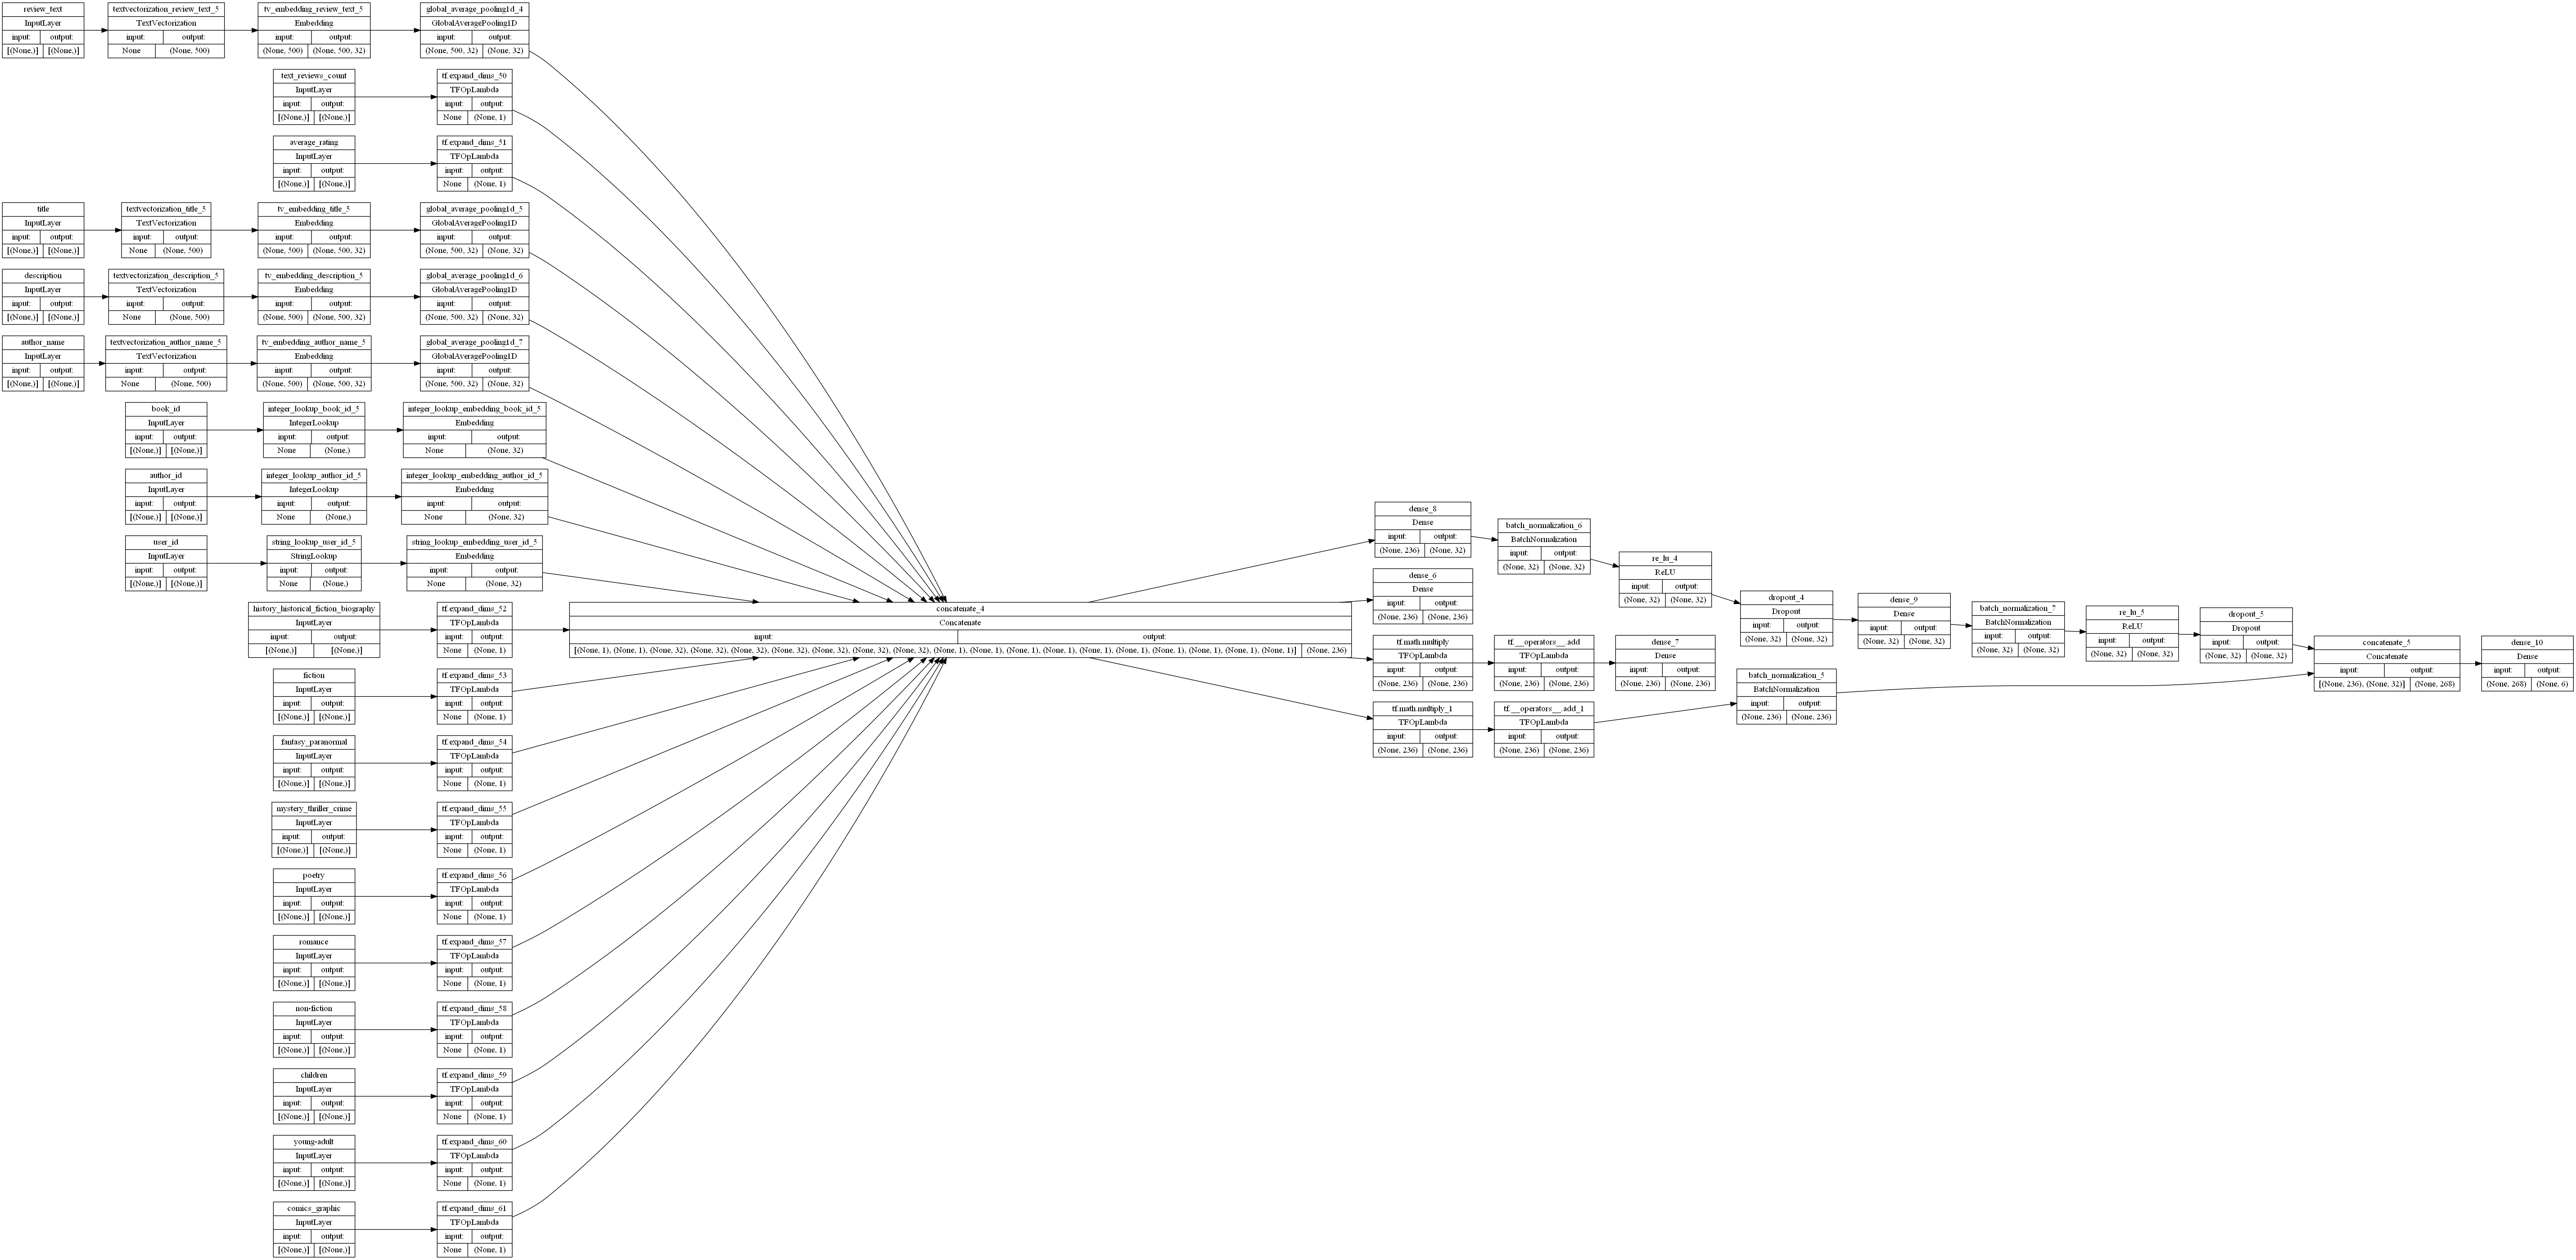

In [ ]:
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
plot_fn = os.path.join("./logs/model_plots/", "deep_and_cross_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")

keras.utils.plot_model(deep_and_cross_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [ ]:
run_experiment(deep_and_cross_model)

setting up yagmail...
Start training the model...
Start Training with Model...
Starting training; got log keys: []
[]
Epoch 1/50
 6/68 [=>............................] - ETA: 6s - loss: 2.0076 - sparse_categorical_accuracy: 0.2669 - sparse_categorical_crossentropy: 2.0076WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0740s vs `on_train_batch_end` time: 0.3235s). Check your callbacks.


68/68 [==============================] - 21s 118ms/step - loss: 1.7007 - sparse_categorical_accuracy: 0.3226 - sparse_categorical_crossentropy: 1.7007
Epoch 2/50
68/68 [==============================] - 10s 147ms/step - loss: 1.4209 - sparse_categorical_accuracy: 0.3825 - sparse_categorical_crossentropy: 1.42093s - loss: 1.4346 - sparse_categorical_accuracy: 0.3857 - sparse_cate
Epoch 3/50
68/68 [==============================] - 8s 116ms/step - loss: 1.3440 - sparse_categorical_accuracy: 0.4195 - sparse_categorical_crossentropy: 1.3440
Epoch 4/50
68/68 [==============================] - 8s 111ms/step - loss: 1.2949 - sparse_categorical_accuracy: 0.4430 - sparse_categorical_crossentropy: 1.2949
Epoch 5/50
68/68 [==============================] - 9s 138ms/step - loss: 1.2401 - sparse_categorical_accuracy: 0.4744 - sparse_categorical_crossentropy: 1.2401
Epoch 6/50
68/68 [==============================] - 7s 100ms/step - loss: 1.1821 - sparse_categorical_accuracy: 0.5081 - sparse_categor

In [ ]:
deep_and_cross_model.save(os.path.join(MODEL_DIR, "deep_and_cross_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

INFO:tensorflow:Assets written to: ./models/deep_and_cross_model_20220125-181545\assets


INFO:tensorflow:Assets written to: ./models/deep_and_cross_model_20220125-181545\assets
